This "Part 2" of the Challenge corresponds to both the Prediction and Exploratory challenges.

# Section 1 - Prediction

First, let's write here the part of the code from the first step of our studies that handles data preparation:

In [187]:
# Imports
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import utm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

# Loading the data
df = pd.read_excel('Households data.xlsx')
f1 = df.drop(columns=['Hogar','EXCLUIR','paraValidacion','CLUSTER7','CLUSTER2'])
f1.columns

# Cleaning the data, removing negative values
f2 = f1[f1.AnosEstudio > 0]
f2 = f2[f2.Tiempo_Com_Stgo > 0]

cols_to_check = f2.columns[(f2 < 0).any()].tolist()
for cols in cols_to_check:
    f3 = f2[f2[cols] > 0]
    
# One-out-of-K encoding
f4 = pd.get_dummies(f3, columns=['Sector'])

# Geographical divison between test and train sets
xMax = -33.40000
xMin = -33.50000
yMin = -70.70000
yMax = -70.60000

maxCoord = utm.from_latlon(xMax, yMax)
minCoord = utm.from_latlon(xMin, yMin)

# Adding places of interest
hosp = utm.from_latlon(-33.392800, -70.572800)
airport = utm.from_latlon(-33.401967, -70.794080)
park = utm.from_latlon(-33.430573, -70.636080)
nhood = utm.from_latlon(-33.417974, -70.553024)

Ahosp = np.array(hosp[0:2])
Aairport = np.array(airport[0:2])
Apark = np.array(park[0:2])
Ahood = np.array(nhood[0:2])

# Making the element wise subtraction for every positions X and Y in the DF with relation to each of the
# 4 positions that we picked.

f4['DistHosp'] = np.linalg.norm(f4[['DirCoordX', 'DirCoordY']].sub(Ahosp), axis=1)
f4['DistAirp'] = np.linalg.norm(f4[['DirCoordX', 'DirCoordY']].sub(Aairport), axis=1)
f4['DistPark'] = np.linalg.norm(f4[['DirCoordX', 'DirCoordY']].sub(Apark), axis=1)
f4['DistHood'] = np.linalg.norm(f4[['DirCoordX', 'DirCoordY']].sub(Ahood), axis=1)

f4['Test'] = np.where(((f4['DirCoordX'] >= minCoord[0]) & (f4['DirCoordX'] <= maxCoord[0])
                      & (f4['DirCoordY'] >= minCoord[1]) & (f4['DirCoordY'] <= maxCoord[1])), 1, 0)

test = f4[f4['Test'] == 1]
training = f4[f4['Test'] == 0]

# Defining x for train and test sets, removing 'CLASE' (Y) and 'Test' columns

x_train = training[['DirCoordX', 'DirCoordY', 'MontoArr', 'IngresoHogar', 'Factor',
       'AnosEstudio', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv',
       'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM',
       'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'Sector_1', 'Sector_2', 'Sector_3', 'Sector_4',
       'Sector_5', 'Sector_6', 'Sector_7', 'DistHosp', 'DistAirp', 'DistPark',
       'DistHood']]

x_test = test[['DirCoordX', 'DirCoordY', 'MontoArr', 'IngresoHogar', 'Factor',
       'AnosEstudio', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv',
       'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM',
       'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'Sector_1', 'Sector_2', 'Sector_3', 'Sector_4',
       'Sector_5', 'Sector_6', 'Sector_7', 'DistHosp', 'DistAirp', 'DistPark',
       'DistHood']]

# Setting the y's

y_train = training['CLASE']
y_test = test['CLASE']

# Normalizing the data
std = preprocessing.StandardScaler().fit(x_train)
x_train_std = std.transform(x_train)
x_test_std = std.transform(x_test)

Let's also visualize our training and test splits on the map, just to make sure it is correct:

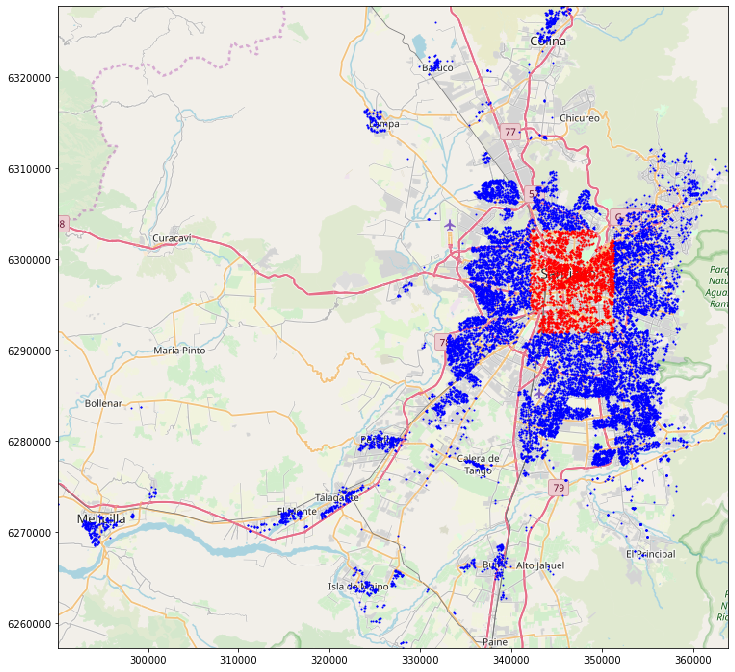

In [2]:
# As seen on https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db
Bound_Box = ((f4.DirCoordX.min(), f4.DirCoordX.max(), f4.DirCoordY.min(), f4.DirCoordY.max()))

Map_San = plt.imread("map.png")
fig, ax = plt.subplots(figsize = (12,15))
ax.scatter(training.DirCoordX, training.DirCoordY, zorder=1, alpha= 1, c='b', s=1)
ax.scatter(test.DirCoordX, test.DirCoordY, zorder=1, alpha= 1, c='r', s=1)
ax.set_xlim(Bound_Box[0],Bound_Box[1])
ax.set_ylim(Bound_Box[2],Bound_Box[3])
ax.imshow(Map_San, zorder=0, extent = Bound_Box, aspect= 'equal')

Awesome, it looks perfect (the image in the project description seems to be inverted, that's why they don't look the same).

Alright, so now the first thing we can do, just like we tried in part one, is to train a model to see what kind of results we have. Let's start with a logistic regression:

In [3]:
lr = LogisticRegression(C=1)
lr.fit(x_train_std, y_train)

# Make predictions from Logistic regression model
y_pred_lr = lr.predict(x_test_std)

# Getting the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_lr))

# Print the evaluation from several metrics
print(metrics.classification_report(y_test, y_pred_lr, digits=3))

C:\Users\peger\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\peger\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[ 691    0    0]
 [   0 1246   14]
 [   0    0  912]]
              precision    recall  f1-score   support

           1      1.000     1.000     1.000       691
           2      1.000     0.989     0.994      1260
           3      0.985     1.000     0.992       912

    accuracy                          0.995      2863
   macro avg      0.995     0.996     0.996      2863
weighted avg      0.995     0.995     0.995      2863



As seen above, the results are really good! For the first and second classes, all observations were predicted succesfully. For the third class, only 14 out of 1246 were predicted as the second class. For the sake of being safe, let's try the same model but checking for overfitting, with different values of C (play with the code above and see the results).

It is very easy to see that any value of C above 5 means overfitting (since there are no misclassifications from that point on).

-------

But, checking the documentation for the project, it is stated that we should not 'give the answer' in our input vector. Therefore, in the attempt of following the guidelines as much as possible, let's remove everything that could tell something about the type of household and somehow 'give the answer' from the input vectors (years of study and income):

In [4]:
# Defining x for train and test sets, removing 'CLASE' (Y), 'Test', anosEstudio and IngresoHogar columns

x_train = training[['DirCoordX', 'DirCoordY', 'MontoArr', 'Factor',
       'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv',
       'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM',
       'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'Sector_1', 'Sector_2', 'Sector_3', 'Sector_4',
       'Sector_5', 'Sector_6', 'Sector_7', 'DistHosp', 'DistAirp', 'DistPark',
       'DistHood']]

x_test = test[['DirCoordX', 'DirCoordY', 'MontoArr', 'Factor',
       'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv',
       'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM',
       'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'Sector_1', 'Sector_2', 'Sector_3', 'Sector_4',
       'Sector_5', 'Sector_6', 'Sector_7', 'DistHosp', 'DistAirp', 'DistPark',
       'DistHood']]

# Setting the y's

y_train = training['CLASE']
y_test = test['CLASE']

# Normalizing the data
std = preprocessing.StandardScaler().fit(x_train)
x_train_std = std.transform(x_train)
x_test_std = std.transform(x_test)

lr = LogisticRegression(C=1)
lr.fit(x_train_std, y_train)

# Make predictions from Logistic regression model
y_pred_lr = lr.predict(x_test_std)

# Getting the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_lr))

# Print the evaluation from several metrics
print(metrics.classification_report(y_test, y_pred_lr, digits=3))

C:\Users\peger\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\peger\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[382 270  39]
 [407 605 248]
 [ 94 336 482]]
              precision    recall  f1-score   support

           1      0.433     0.553     0.485       691
           2      0.500     0.480     0.490      1260
           3      0.627     0.529     0.573       912

    accuracy                          0.513      2863
   macro avg      0.520     0.520     0.516      2863
weighted avg      0.524     0.513     0.515      2863



The results are obviously very bad, mainly due to the removal of the attribute that corresponded to years of study of the household head. Out of all the attributes, the one that presented the biggest correlation with CLASE was exactly that one (0,89).

For the sake of completion, let's try other algorithms:

In [173]:
# Support vector machine
sv = SVC(gamma='auto')
sv.fit(x_train,y_train)
sv.score(x_test, y_test)

0.4400977995110024

In [174]:
ypred = sv.predict(x_test)
confusion_matrix(y_test, ypred)

array([[   0,  691,    0],
       [   0, 1260,    0],
       [   0,  912,    0]], dtype=int64)

In [5]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt.score(x_test,y_test)

0.3835137967167307

In [6]:
ypred = dt.predict(x_test)
confusion_matrix(y_test, ypred)

array([[321, 299,  71],
       [541, 481, 238],
       [402, 214, 296]], dtype=int64)

In [7]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(x_train, y_train)
print(rf.score(x_test, y_test))

0.41529863779252535


As expected, the problem was not with our algorithm, but rather with the data set itself. We have to try some further pre-processing techniques to see if we can improve our results. One way is to remove the coordinates from the input vector, perform PCA in order to hopefully get some transformed attributes that will help us, and then use the coordinates again to be able to divide between test and train sets (we have created a column called 'Test' that makes this part easier). 

[0.47656829476507284,
 0.6029929442111379,
 0.6790200673651106,
 0.7412036404476723,
 0.7882482276784457,
 0.8317343916925846,
 0.8639794321651736,
 0.8915634840357721,
 0.9146919589877562,
 0.932661765938044,
 0.9465669668743798,
 0.9579806167552476,
 0.967838867820995,
 0.9767286755952784,
 0.9848072514645757,
 0.9921633101597113,
 0.995142039127094,
 0.9971059975308137,
 0.9982729024990146,
 0.9991688370493139,
 0.9994827744739264,
 0.9996922864004885,
 0.9998042017374061,
 0.9998954728129236,
 0.9999478892159892,
 0.9999739903555004,
 0.9999966138373567,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999]

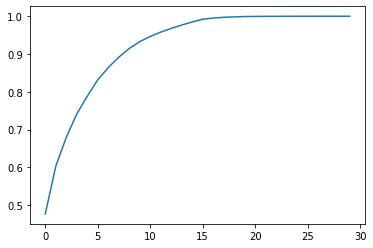

In [8]:
df = f4.drop(columns=['DirCoordX','DirCoordY','IngresoHogar','AnosEstudio', 'CLASE', 'Test'])
df_std = (df - df.mean()) / df.std()
df2 = df_std.copy()
pca = PCA()
pca.fit(df_std)

# Ass seen on our notebooks 
expl = pca.explained_variance_ratio_
cdf = [sum(expl[:i+1]) for i in range(len(expl))]
plt.plot(range(len(expl)), cdf);
cdf

So let's go ahead and pick the first 12 components, which account for more than 95% of the variance

In [9]:
pca_new = decomposition.PCA(n_components=12)
pca_new.fit(df2)
X_reduced = pca_new.transform(df2)
dt_reduced = pd.DataFrame(X_reduced)
fnew = dt_reduced.copy()

Adding back the test and y columns:

In [10]:
fnew = fnew.set_index(f4.index)
fnew['Test'] = f4['Test']
fnew['CLASE'] = f4['CLASE']

Let's try to predict now...

In [11]:
test2 = fnew[fnew['Test'] == 1]
training2 = fnew[fnew['Test'] == 0]

x_train2 = training2.drop(columns=['Test', 'CLASE'])

x_test2 = test2.drop(columns=['Test', 'CLASE'])

# Setting the y's
y_train2 = training2['CLASE']
y_test2 = test2['CLASE']

lr2 = LogisticRegression(C=100)
lr2.fit(x_train2, y_train2)

# Make predictions from Logistic regression model
y_pred_lr2 = lr2.predict(x_test2)

# Getting the confusion matrix
print(metrics.confusion_matrix(y_test2, y_pred_lr2))

# Print the evaluation from several metrics
print(metrics.classification_report(y_test2, y_pred_lr2, digits=3))

C:\Users\peger\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\peger\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[275 248 168]
 [219 385 656]
 [ 33 132 747]]
              precision    recall  f1-score   support

           1      0.522     0.398     0.452       691
           2      0.503     0.306     0.380      1260
           3      0.475     0.819     0.602       912

    accuracy                          0.491      2863
   macro avg      0.500     0.508     0.478      2863
weighted avg      0.499     0.491     0.468      2863



In [12]:
dt2 = DecisionTreeClassifier()
dt2.fit(x_train2, y_train2)
dt2.score(x_test2,y_test2)

0.40936081033880545

In [13]:
ypred2 = dt2.predict(x_test2)
confusion_matrix(y_test2, ypred2)

array([[290, 310,  91],
       [392, 520, 348],
       [156, 394, 362]], dtype=int64)

In [14]:
rf2 = RandomForestClassifier(n_estimators=10)
rf2.fit(x_train2, y_train2)
print(rf2.score(x_test2, y_test2))

0.4910932588194202


The results are insignificant for all methods, especially when looking at the confusion matrices (prediction of CLASE = 3 for logistic regression did a little bit better). It has now come to our attention that we don't know exactly what the attribute CLASE means. We posted a questions on inside (kinda late, but still...) to see if we can get some insight on it, with the hope to get a chance to add more data to our set and increase the prediction accuracy.

As a last resort, let's load more data that were found from "Facebook Connectivity Lab and Center for International Earth Science Information Network - CIESIN - Columbia University. 2016. High Resolution Settlement Layer (HRSL). Source imagery for HRSL © 2016 DigitalGlobe." Accessed 06/12/2019, which gives us the youth (15 to 24 yo), elderly (plus 60) and kids under 5 yo population by coordinates.

In [387]:
nf1 = pd.read_csv('plus60.csv')
nf2 = pd.read_csv('youth15_24.csv')
nf3 = pd.read_csv('children5.csv')

In [388]:
# Renaming columns and merging dataframes
nf1.rename(columns={'population': 'plus60Pop'}, inplace=True)
nf1['youthPop'] = 0
nf1['under5Pop'] = 0

nf2.rename(columns={'population': 'youthPop'}, inplace=True)
nf2['plus60Pop'] = 0
nf2['under5Pop'] = 0

nf3.rename(columns={'population': 'under5Pop'}, inplace=True)
nf3['youthPop'] = 0
nf3['plus60Pop'] = 0

In [389]:
pop_df = pd.concat([nf1, nf2, nf3], axis=0, sort=False)

In [390]:
pop_df = pop_df.groupby(['latitude','longitude']).sum().reset_index()
pop_df.describe()

,latitude,longitude,plus60Pop,youthPop,under5Pop
count,3.677021e+06,3.677021e+06,3.677021e+06,3.677021e+06,3.677021e+06
mean,-3.575953e+01,-7.164121e+01,5.303483e-01,8.456611e-01,3.587321e-01
std,5.080886e+00,1.015944e+00,5.244215e-01,9.556647e-01,4.082446e-01
min,-5.598014e+01,-7.567403e+01,3.440000e-03,2.671000e-03,0.000000e+00
25%,-3.801292e+01,-7.242125e+01,2.069330e-01,2.908830e-01,1.281000e-01
50%,-3.475875e+01,-7.148153e+01,3.017970e-01,4.627920e-01,2.095080e-01
75%,-3.341903e+01,-7.081625e+01,6.337480e-01,1.153166e+00,4.386740e-01
max,-1.755903e+01,-6.641958e+01,3.137348e+00,5.488883e+00,2.371383e+00


Ok, so, we have more than 3.6 million lines, let's remove the ones that we don't need:

In [391]:
a = utm.to_latlon(f4.DirCoordX.min(), f4.DirCoordY.max(), 19, 'H')
b = utm.to_latlon(f4.DirCoordX.max(), f4.DirCoordY.min(), 19, 'H')

# Dropping things that are not in within any of our data points in Santiago
pop_df.drop(pop_df[pop_df.latitude < b[0]].index, inplace=True)
pop_df.drop(pop_df[pop_df.latitude > a[0]].index, inplace=True)
pop_df.drop(pop_df[pop_df.longitude > b[1]].index, inplace=True)
pop_df.drop(pop_df[pop_df.longitude < a[1]].index, inplace=True)

In [392]:
pop_df.describe()

,latitude,longitude,plus60Pop,youthPop,under5Pop
count,692323.000000,692323.000000,692323.000000,692323.000000,692323.000000
mean,-33.500001,-70.728339,1.073759,1.798948,0.771933
std,0.138921,0.172052,0.762455,1.430513,0.616341
min,-33.815972,-71.249861,0.134850,0.225804,0.103254
25%,-33.596528,-70.785694,0.303963,0.571156,0.271525
50%,-33.492361,-70.689306,1.113244,1.376857,0.552214
75%,-33.406250,-70.601528,1.574201,2.387111,1.116782
max,-33.168194,-70.471528,3.137348,5.488883,2.353735


Much better now with less than 700k lines.

Alright, let's transform the coordinates to utm:

In [393]:
def lat_df(lat, lon):
    x = list(utm.from_latlon(lat, lon))
    return x[0]

def lon_df(lat, lon):
    x = list(utm.from_latlon(lat, lon))
    return x[1]

In [394]:
# Since the process below was taking a while, implemented a progress indicator as seen on
# https://stackoverflow.com/questions/18603270/progress-indicator-during-pandas-operations

# We know this could have been done in one operation, but we were having some memory problems.

tqdm.pandas()

pop_df['DirCoordX'] = pop_df.progress_apply(lambda row: lat_df(row.latitude, row.longitude), axis=1)











  0%|                                                                                       | 0/692323 [00:00<?, ?it/s]









  0%|                                                                           | 418/692323 [00:00<03:03, 3761.88it/s]









  0%|▏                                                                         | 1213/692323 [00:00<02:38, 4361.91it/s]









  0%|▏                                                                         | 1803/692323 [00:00<02:26, 4712.90it/s]









  0%|▎                                                                         | 2610/692323 [00:00<02:08, 5379.56it/s]









  0%|▎                                                                         | 3429/692323 [00:00<01:55, 5989.90it/s]









  1%|▍                                                                         | 4357/692323 [00:00<01:45, 6499.76it/s]









  1%|▌                                                                         | 5145/6

  8%|█████▊                                                                   | 54709/692323 [00:06<01:22, 7771.61it/s]









  8%|█████▊                                                                   | 55564/692323 [00:06<01:19, 7989.54it/s]









  8%|█████▉                                                                   | 56372/692323 [00:07<01:19, 7998.18it/s]









  8%|██████                                                                   | 57365/692323 [00:07<01:17, 8173.17it/s]









  8%|██████▏                                                                  | 58276/692323 [00:07<01:15, 8429.10it/s]









  9%|██████▎                                                                  | 59343/692323 [00:07<01:13, 8667.94it/s]









  9%|██████▎                                                                  | 60216/692323 [00:07<01:12, 8662.23it/s]









  9%|██████▍                                                                  | 61087/692323 [00:

 16%|███████████▊                                                            | 113988/692323 [00:13<01:03, 9125.75it/s]









 17%|███████████▉                                                            | 114902/692323 [00:13<01:03, 9104.78it/s]









 17%|████████████                                                            | 115976/692323 [00:13<01:02, 9171.61it/s]









 17%|████████████▏                                                           | 116944/692323 [00:13<01:01, 9290.37it/s]









 17%|████████████▎                                                           | 117874/692323 [00:14<01:01, 9290.61it/s]









 17%|████████████▎                                                           | 118878/692323 [00:14<01:02, 9110.04it/s]









 17%|████████████▍                                                           | 119848/692323 [00:14<01:01, 9268.10it/s]









 17%|████████████▌                                                           | 120793/692323 [00:

 25%|██████████████████▏                                                     | 174671/692323 [00:20<00:59, 8635.02it/s]









 25%|██████████████████▎                                                     | 175552/692323 [00:20<00:59, 8673.97it/s]









 25%|██████████████████▎                                                     | 176424/692323 [00:20<00:59, 8643.86it/s]









 26%|██████████████████▍                                                     | 177313/692323 [00:20<00:59, 8710.61it/s]









 26%|██████████████████▌                                                     | 178239/692323 [00:20<00:57, 8866.53it/s]









 26%|██████████████████▋                                                     | 179153/692323 [00:20<00:57, 8929.61it/s]









 26%|██████████████████▋                                                     | 180072/692323 [00:20<00:57, 8981.40it/s]









 26%|██████████████████▊                                                     | 180989/692323 [00:

 34%|████████████████████████▍                                               | 234641/692323 [00:26<00:51, 8877.40it/s]









 34%|████████████████████████▍                                               | 235545/692323 [00:26<00:51, 8906.29it/s]









 34%|████████████████████████▌                                               | 236437/692323 [00:27<00:51, 8781.40it/s]









 34%|████████████████████████▋                                               | 237370/692323 [00:27<00:50, 8927.81it/s]









 34%|████████████████████████▊                                               | 238427/692323 [00:27<00:49, 9127.16it/s]









 35%|████████████████████████▉                                               | 239390/692323 [00:27<00:48, 9243.83it/s]









 35%|████████████████████████▉                                               | 240317/692323 [00:27<00:51, 8812.64it/s]









 35%|█████████████████████████                                               | 241376/692323 [00:

 43%|██████████████████████████████▋                                         | 295247/692323 [00:33<00:44, 8942.09it/s]









 43%|██████████████████████████████▊                                         | 296186/692323 [00:33<00:43, 9029.88it/s]









 43%|██████████████████████████████▉                                         | 297274/692323 [00:33<00:42, 9199.03it/s]









 43%|███████████████████████████████                                         | 298196/692323 [00:33<00:42, 9192.25it/s]









 43%|███████████████████████████████                                         | 299117/692323 [00:33<00:43, 8947.04it/s]









 43%|███████████████████████████████▏                                        | 300136/692323 [00:34<00:43, 9101.18it/s]









 43%|███████████████████████████████▎                                        | 301098/692323 [00:34<00:42, 9196.12it/s]









 44%|███████████████████████████████▍                                        | 302222/692323 [00:

 52%|█████████████████████████████████████▏                                  | 357514/692323 [00:40<00:36, 9242.77it/s]









 52%|█████████████████████████████████████▎                                  | 358439/692323 [00:40<00:37, 8833.10it/s]









 52%|█████████████████████████████████████▎                                  | 359360/692323 [00:40<00:37, 8902.62it/s]









 52%|█████████████████████████████████████▍                                  | 360437/692323 [00:40<00:36, 9030.84it/s]









 52%|█████████████████████████████████████▌                                  | 361346/692323 [00:40<00:36, 9010.25it/s]









 52%|█████████████████████████████████████▋                                  | 362419/692323 [00:40<00:36, 9119.64it/s]









 52%|█████████████████████████████████████▊                                  | 363373/692323 [00:40<00:35, 9226.57it/s]









 53%|█████████████████████████████████████▉                                  | 364333/692323 [00:

 61%|███████████████████████████████████████████▋                            | 419814/692323 [00:46<00:29, 9223.53it/s]









 61%|███████████████████████████████████████████▊                            | 420739/692323 [00:47<00:30, 8786.31it/s]









 61%|███████████████████████████████████████████▊                            | 421624/692323 [00:47<00:30, 8784.93it/s]









 61%|███████████████████████████████████████████▉                            | 422507/692323 [00:47<00:31, 8578.74it/s]









 61%|████████████████████████████████████████████                            | 423537/692323 [00:47<00:30, 8872.47it/s]









 61%|████████████████████████████████████████████▏                           | 424515/692323 [00:47<00:29, 9107.32it/s]









 61%|████████████████████████████████████████████▎                           | 425574/692323 [00:47<00:29, 9138.68it/s]









 62%|████████████████████████████████████████████▎                           | 426521/692323 [00:

 69%|██████████████████████████████████████████████████                      | 481036/692323 [00:53<00:22, 9337.06it/s]









 70%|██████████████████████████████████████████████████                      | 481971/692323 [00:53<00:22, 9285.76it/s]









 70%|██████████████████████████████████████████████████▏                     | 482901/692323 [00:53<00:22, 9289.89it/s]









 70%|██████████████████████████████████████████████████▎                     | 483831/692323 [00:53<00:22, 9215.85it/s]









 70%|██████████████████████████████████████████████████▍                     | 484870/692323 [00:54<00:22, 9207.69it/s]









 70%|██████████████████████████████████████████████████▌                     | 485876/692323 [00:54<00:21, 9418.38it/s]









 70%|██████████████████████████████████████████████████▋                     | 486841/692323 [00:54<00:21, 9481.65it/s]









 70%|██████████████████████████████████████████████████▋                     | 487917/692323 [00:

 78%|████████████████████████████████████████████████████████▍               | 542882/692323 [01:00<00:15, 9410.90it/s]









 79%|████████████████████████████████████████████████████████▌               | 544002/692323 [01:00<00:15, 9514.06it/s]









 79%|████████████████████████████████████████████████████████▋               | 544955/692323 [01:00<00:15, 9444.96it/s]









 79%|████████████████████████████████████████████████████████▊               | 545995/692323 [01:00<00:15, 9338.89it/s]









 79%|████████████████████████████████████████████████████████▉               | 546930/692323 [01:00<00:15, 9290.57it/s]









 79%|████████████████████████████████████████████████████████▉               | 548065/692323 [01:00<00:15, 9454.30it/s]









 79%|█████████████████████████████████████████████████████████               | 549012/692323 [01:00<00:15, 9418.65it/s]









 79%|█████████████████████████████████████████████████████████▏              | 550079/692323 [01:

 87%|██████████████████████████████████████████████████████████████▉         | 605426/692323 [01:06<00:09, 8994.85it/s]









 88%|███████████████████████████████████████████████████████████████         | 606376/692323 [01:07<00:09, 9139.90it/s]









 88%|███████████████████████████████████████████████████████████████▏        | 607313/692323 [01:07<00:09, 9169.18it/s]









 88%|███████████████████████████████████████████████████████████████▎        | 608254/692323 [01:07<00:09, 9238.40it/s]









 88%|███████████████████████████████████████████████████████████████▎        | 609330/692323 [01:07<00:08, 9279.26it/s]









 88%|███████████████████████████████████████████████████████████████▍        | 610282/692323 [01:07<00:08, 9314.28it/s]









 88%|███████████████████████████████████████████████████████████████▌        | 611397/692323 [01:07<00:08, 9424.01it/s]









 88%|███████████████████████████████████████████████████████████████▋        | 612341/692323 [01:

 96%|█████████████████████████████████████████████████████████████████████▍  | 667807/692323 [01:13<00:02, 9342.94it/s]









 97%|█████████████████████████████████████████████████████████████████████▌  | 668855/692323 [01:13<00:02, 9268.06it/s]









 97%|█████████████████████████████████████████████████████████████████████▋  | 669783/692323 [01:13<00:02, 9207.20it/s]









 97%|█████████████████████████████████████████████████████████████████████▊  | 670897/692323 [01:13<00:02, 9356.54it/s]









 97%|█████████████████████████████████████████████████████████████████████▊  | 671834/692323 [01:14<00:02, 9295.70it/s]









 97%|█████████████████████████████████████████████████████████████████████▉  | 672765/692323 [01:14<00:02, 9282.82it/s]









 97%|██████████████████████████████████████████████████████████████████████  | 673694/692323 [01:14<00:02, 8880.94it/s]









 97%|██████████████████████████████████████████████████████████████████████▏ | 674768/692323 [01:

In [395]:
pop_df.head()

,latitude,longitude,plus60Pop,youthPop,under5Pop,DirCoordX
2186258,-33.815972,-71.247361,0.223361,0.363867,0.166004,291994.137100
2186259,-33.815972,-71.247083,0.223361,0.363867,0.166004,292019.854102
2186260,-33.815972,-71.246806,0.223361,0.363867,0.166004,292045.561846
2186261,-33.815972,-71.246528,0.223361,0.363867,0.166004,292071.278845
2186262,-33.815972,-71.245972,0.223361,0.363867,0.166004,292122.712837


It works, so let's do the same for Y and drop the original columns:

In [396]:
pop_df['DirCoordY'] = pop_df.progress_apply(lambda row: lon_df(row.latitude, row.longitude), axis=1)
pop_df.head()











  0%|                                                                                       | 0/692323 [00:00<?, ?it/s]









  0%|                                                                           | 389/692323 [00:00<03:22, 3410.94it/s]









  0%|                                                                          | 1046/692323 [00:00<02:53, 3980.26it/s]









  0%|▏                                                                         | 2026/692323 [00:00<02:25, 4746.36it/s]









  0%|▎                                                                         | 2922/692323 [00:00<02:05, 5508.99it/s]









  1%|▍                                                                         | 3915/692323 [00:00<01:51, 6183.73it/s]









  1%|▌                                                                         | 4795/692323 [00:00<01:41, 6759.95it/s]









  1%|▌                                                                         | 5705/6

  9%|██████▎                                                                  | 59490/692323 [00:06<01:09, 9161.11it/s]









  9%|██████▍                                                                  | 60464/692323 [00:06<01:10, 8953.73it/s]









  9%|██████▍                                                                  | 61361/692323 [00:06<01:10, 8945.63it/s]









  9%|██████▌                                                                  | 62316/692323 [00:06<01:09, 9114.88it/s]









  9%|██████▋                                                                  | 63274/692323 [00:07<01:08, 9245.65it/s]









  9%|██████▊                                                                  | 64208/692323 [00:07<01:07, 9252.72it/s]









  9%|██████▉                                                                  | 65304/692323 [00:07<01:07, 9352.07it/s]









 10%|██████▉                                                                  | 66241/692323 [00:

 18%|████████████▌                                                           | 121170/692323 [00:13<01:00, 9380.88it/s]









 18%|████████████▋                                                           | 122274/692323 [00:13<01:00, 9454.56it/s]









 18%|████████████▊                                                           | 123221/692323 [00:13<01:00, 9374.66it/s]









 18%|████████████▉                                                           | 124304/692323 [00:13<01:00, 9396.95it/s]









 18%|█████████████                                                           | 125245/692323 [00:13<01:00, 9397.16it/s]









 18%|█████████████▏                                                          | 126212/692323 [00:13<00:59, 9455.23it/s]









 18%|█████████████▏                                                          | 127158/692323 [00:13<00:59, 9455.93it/s]









 19%|█████████████▎                                                          | 128104/692323 [00:

 26%|███████████████████                                                     | 182786/692323 [00:19<00:55, 9260.04it/s]









 27%|███████████████████                                                     | 183747/692323 [00:20<00:54, 9329.22it/s]









 27%|███████████████████▏                                                    | 184786/692323 [00:20<00:54, 9237.77it/s]









 27%|███████████████████▎                                                    | 185927/692323 [00:20<00:53, 9422.33it/s]









 27%|███████████████████▍                                                    | 186871/692323 [00:20<00:53, 9375.92it/s]









 27%|███████████████████▌                                                    | 187861/692323 [00:20<00:53, 9515.67it/s]









 27%|███████████████████▋                                                    | 188814/692323 [00:20<00:52, 9518.39it/s]









 27%|███████████████████▋                                                    | 189767/692323 [00:

 35%|█████████████████████████▍                                              | 244866/692323 [00:26<00:47, 9330.03it/s]









 36%|█████████████████████████▌                                              | 245803/692323 [00:26<00:47, 9322.28it/s]









 36%|█████████████████████████▋                                              | 246789/692323 [00:26<00:47, 9431.47it/s]









 36%|█████████████████████████▊                                              | 247831/692323 [00:26<00:47, 9339.36it/s]









 36%|█████████████████████████▊                                              | 248790/692323 [00:27<00:47, 9378.57it/s]









 36%|█████████████████████████▉                                              | 249757/692323 [00:27<00:46, 9459.38it/s]









 36%|██████████████████████████                                              | 250704/692323 [00:27<00:46, 9407.53it/s]









 36%|██████████████████████████▏                                             | 251814/692323 [00:

 44%|███████████████████████████████▊                                        | 306425/692323 [00:33<00:42, 9145.34it/s]









 44%|███████████████████████████████▉                                        | 307498/692323 [00:33<00:41, 9220.67it/s]









 45%|████████████████████████████████                                        | 308451/692323 [00:33<00:41, 9299.10it/s]









 45%|████████████████████████████████▏                                       | 309382/692323 [00:33<00:41, 9287.39it/s]









 45%|████████████████████████████████▎                                       | 310394/692323 [00:33<00:41, 9132.38it/s]









 45%|████████████████████████████████▍                                       | 311324/692323 [00:33<00:41, 9175.09it/s]









 45%|████████████████████████████████▍                                       | 312406/692323 [00:34<00:41, 9247.82it/s]









 45%|████████████████████████████████▌                                       | 313387/692323 [00:

 53%|██████████████████████████████████████▏                                 | 367666/692323 [00:40<00:34, 9332.54it/s]









 53%|██████████████████████████████████████▎                                 | 368700/692323 [00:40<00:35, 9220.41it/s]









 53%|██████████████████████████████████████▍                                 | 369623/692323 [00:40<00:35, 9192.78it/s]









 54%|██████████████████████████████████████▌                                 | 370628/692323 [00:40<00:35, 9037.55it/s]









 54%|██████████████████████████████████████▋                                 | 371533/692323 [00:40<00:35, 9030.72it/s]









 54%|██████████████████████████████████████▋                                 | 372437/692323 [00:40<00:35, 8992.12it/s]









 54%|██████████████████████████████████████▊                                 | 373497/692323 [00:40<00:35, 9069.49it/s]









 54%|██████████████████████████████████████▉                                 | 374405/692323 [00:

 62%|████████████████████████████████████████████▌                           | 428627/692323 [00:46<00:28, 9366.95it/s]









 62%|████████████████████████████████████████████▋                           | 429565/692323 [00:46<00:28, 9355.27it/s]









 62%|████████████████████████████████████████████▊                           | 430501/692323 [00:46<00:28, 9061.81it/s]









 62%|████████████████████████████████████████████▉                           | 431521/692323 [00:47<00:28, 9278.09it/s]









 62%|████████████████████████████████████████████▉                           | 432452/692323 [00:47<00:27, 9283.07it/s]









 63%|█████████████████████████████████████████████                           | 433389/692323 [00:47<00:27, 9307.70it/s]









 63%|█████████████████████████████████████████████▏                          | 434351/692323 [00:47<00:27, 9389.71it/s]









 63%|█████████████████████████████████████████████▎                          | 435292/692323 [00:

 71%|██████████████████████████████████████████████████▉                     | 489637/692323 [00:53<00:22, 8934.72it/s]









 71%|███████████████████████████████████████████████████                     | 490578/692323 [00:53<00:22, 9039.02it/s]









 71%|███████████████████████████████████████████████████                     | 491485/692323 [00:53<00:23, 8603.07it/s]









 71%|███████████████████████████████████████████████████▏                    | 492561/692323 [00:53<00:22, 8826.12it/s]









 71%|███████████████████████████████████████████████████▎                    | 493507/692323 [00:53<00:22, 8996.20it/s]









 71%|███████████████████████████████████████████████████▍                    | 494476/692323 [00:53<00:21, 9192.12it/s]









 72%|███████████████████████████████████████████████████▌                    | 495400/692323 [00:54<00:21, 9206.32it/s]









 72%|███████████████████████████████████████████████████▌                    | 496324/692323 [00:

 79%|█████████████████████████████████████████████████████████▏              | 550256/692323 [01:00<00:15, 9299.72it/s]









 80%|█████████████████████████████████████████████████████████▎              | 551187/692323 [01:00<00:15, 8912.38it/s]









 80%|█████████████████████████████████████████████████████████▍              | 552082/692323 [01:00<00:15, 8889.16it/s]









 80%|█████████████████████████████████████████████████████████▌              | 553146/692323 [01:00<00:15, 8983.58it/s]









 80%|█████████████████████████████████████████████████████████▌              | 554047/692323 [01:00<00:15, 8987.87it/s]









 80%|█████████████████████████████████████████████████████████▋              | 554978/692323 [01:00<00:15, 9070.38it/s]









 80%|█████████████████████████████████████████████████████████▊              | 555887/692323 [01:00<00:15, 9057.53it/s]









 80%|█████████████████████████████████████████████████████████▉              | 556943/692323 [01:

 88%|███████████████████████████████████████████████████████████████▌        | 611307/692323 [01:06<00:08, 9018.24it/s]









 88%|███████████████████████████████████████████████████████████████▋        | 612210/692323 [01:06<00:08, 8993.31it/s]









 89%|███████████████████████████████████████████████████████████████▊        | 613112/692323 [01:06<00:08, 8998.35it/s]









 89%|███████████████████████████████████████████████████████████████▊        | 614043/692323 [01:07<00:08, 9084.91it/s]









 89%|███████████████████████████████████████████████████████████████▉        | 615142/692323 [01:07<00:08, 9274.15it/s]









 89%|████████████████████████████████████████████████████████████████        | 616099/692323 [01:07<00:08, 9318.62it/s]









 89%|████████████████████████████████████████████████████████████████▏       | 617060/692323 [01:07<00:08, 9374.90it/s]









 89%|████████████████████████████████████████████████████████████████▎       | 617999/692323 [01:

 97%|█████████████████████████████████████████████████████████████████████▊  | 671813/692323 [01:13<00:02, 9181.09it/s]









 97%|█████████████████████████████████████████████████████████████████████▉  | 672732/692323 [01:13<00:02, 8770.10it/s]









 97%|██████████████████████████████████████████████████████████████████████  | 673638/692323 [01:13<00:02, 8850.31it/s]









 97%|██████████████████████████████████████████████████████████████████████▏ | 674527/692323 [01:13<00:02, 8489.14it/s]









 98%|██████████████████████████████████████████████████████████████████████▏ | 675382/692323 [01:13<00:02, 8290.02it/s]









 98%|██████████████████████████████████████████████████████████████████████▎ | 676216/692323 [01:13<00:01, 8166.97it/s]









 98%|██████████████████████████████████████████████████████████████████████▍ | 677037/692323 [01:13<00:01, 8137.80it/s]









 98%|██████████████████████████████████████████████████████████████████████▍ | 677860/692323 [01:

,latitude,longitude,plus60Pop,youthPop,under5Pop,DirCoordX,DirCoordY
2186258,-33.815972,-71.247361,0.223361,0.363867,0.166004,291994.137100,6.255977e+06
2186259,-33.815972,-71.247083,0.223361,0.363867,0.166004,292019.854102,6.255978e+06
2186260,-33.815972,-71.246806,0.223361,0.363867,0.166004,292045.561846,6.255978e+06
2186261,-33.815972,-71.246528,0.223361,0.363867,0.166004,292071.278845,6.255979e+06
2186262,-33.815972,-71.245972,0.223361,0.363867,0.166004,292122.712837,6.255980e+06


In [397]:
pop_df = pop_df.drop(columns=['latitude','longitude'])

In [398]:
pop_df.describe()

,plus60Pop,youthPop,under5Pop,DirCoordX,DirCoordY
count,692323.000000,692323.000000,692323.000000,692323.000000,6.923230e+05
mean,1.073759,1.798948,0.771933,339460.149074,6.291930e+06
std,0.762455,1.430513,0.616341,15905.767614,1.548523e+04
min,0.134850,0.225804,0.103254,290365.715424,6.255977e+06
25%,0.303963,0.571156,0.271525,334139.551448,6.281281e+06
50%,1.113244,1.376857,0.552214,342985.382295,6.292799e+06
75%,1.574201,2.387111,1.116782,351242.631529,6.302388e+06
max,3.137348,5.488883,2.353735,363456.929708,6.328880e+06


Let's now merge with our existing dataframe:

In [650]:
pop2 = pop_df.copy()
fx = f4.copy()

In [651]:
pop2 = pop2.round({'DirCoordX':-1, 'DirCoordY':-2})
fx = fx.round({'DirCoordX':-1, 'DirCoordY':-2})
pop2 = pop2.reset_index(drop=True)

In [652]:
final = pd.merge(pop2, fx, on=['DirCoordX', 'DirCoordY'] ,how='inner')

In [653]:
final = final.drop(columns=['IngresoHogar', 'AnosEstudio'])

test3 = final[final['Test'] == 1]
training3 = final[final['Test'] == 0]

x_train3 = training3[['plus60Pop', 'youthPop', 'under5Pop', 'DirCoordX', 'DirCoordY',
       'MontoArr', 'Sup_Prom_Constr_Hab_EOD',
       'Calid_EOD_norm_inv', 'DensConstr_EOD', 'Dist_est_Metro_MC_KM',
       'Tiempo_Com_Stgo',
       'Ingreso_Promedio_Zona_MM', 'Acc_Servicios_tpte_pub','Sector_3', 'Sector_4',
       'Sector_5','Sector_7', 'DistHosp', 'DistAirp', 'DistPark',
       'DistHood']]

x_test3 = test3[['plus60Pop', 'youthPop', 'under5Pop', 'DirCoordX', 'DirCoordY',
       'MontoArr', 'Sup_Prom_Constr_Hab_EOD',
       'Calid_EOD_norm_inv', 'DensConstr_EOD', 'Dist_est_Metro_MC_KM',
       'Tiempo_Com_Stgo',
       'Ingreso_Promedio_Zona_MM', 'Acc_Servicios_tpte_pub','Sector_3', 'Sector_4',
       'Sector_5','Sector_7', 'DistHosp', 'DistAirp', 'DistPark',
       'DistHood']]

# Setting the y's

y_train3 = training3['CLASE']
y_test3 = test3['CLASE']

# Normalizing the data
std = preprocessing.StandardScaler().fit(x_train3)
x_train_std3 = std.transform(x_train3)
x_test_std3 = std.transform(x_test3)

lr = LogisticRegression(C=1)
lr.fit(x_train_std3, y_train3)

# Make predictions from Logistic regression model
y_pred_lr3 = lr.predict(x_test_std3)

# Getting the confusion matrix
print(metrics.confusion_matrix(y_test3, y_pred_lr3))

# Print the evaluation from several metrics
print(metrics.classification_report(y_test3, y_pred_lr3, digits=3))

C:\Users\peger\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\peger\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[178 263  50]
 [160 467 243]
 [ 30 173 396]]
              precision    recall  f1-score   support

           1      0.484     0.363     0.414       491
           2      0.517     0.537     0.527       870
           3      0.575     0.661     0.615       599

    accuracy                          0.531      1960
   macro avg      0.525     0.520     0.519      1960
weighted avg      0.526     0.531     0.526      1960



Slightly better results with some feature selection (ran manual forward selection). Unfortunately that is all we have in our bag of possible solution for this part of the project.

# Section 2 - Exploratory

For this section, let's say we want to help a local commerce in targeting their marketing campaigns throughout this territory, taking into account the purchasing power of their costumers which, in theory, should go hand-in-hand with how much money they earn, how much they pay for their houses monthly, etc.

First let's plot a histogram of the attribute that shows us the years of study:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016A2665C898>]],
      dtype=object)

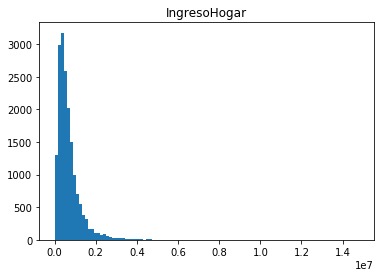

In [188]:
f4.hist(column='IngresoHogar', bins=100, grid=False)

Okay, that is not telling us much. Let's try something else, like how much they pay of dwelling rent in their homes:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016A254BA780>]],
      dtype=object)

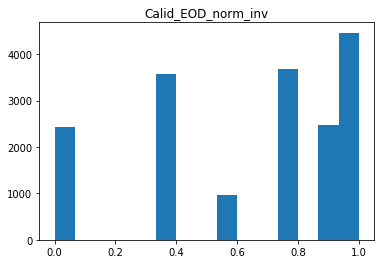

In [189]:
f4.hist(column='Calid_EOD_norm_inv', bins=15, grid=False)

Alright, this one is definitely showing us some sort of division (makes sinces, since it is an average for construction quality in different areas). So let's go ahead and find those clusters, also plotting them on the map:

In [190]:
# let's choose 5, since it seems like it's the least amount of divisions suggested by our histogram (different number of
# bins were tried)
K = 5
k = KMeans(K)

f5 = f4[['Calid_EOD_norm_inv']]

k.fit(f5,f5.index);
f5_clusters = f5.copy()
f5_clusters['cluster'] = k.fit_predict(f5)
f5_clusters['dirX'] = f4[['DirCoordX']]
f5_clusters['dirY'] = f4[['DirCoordY']]

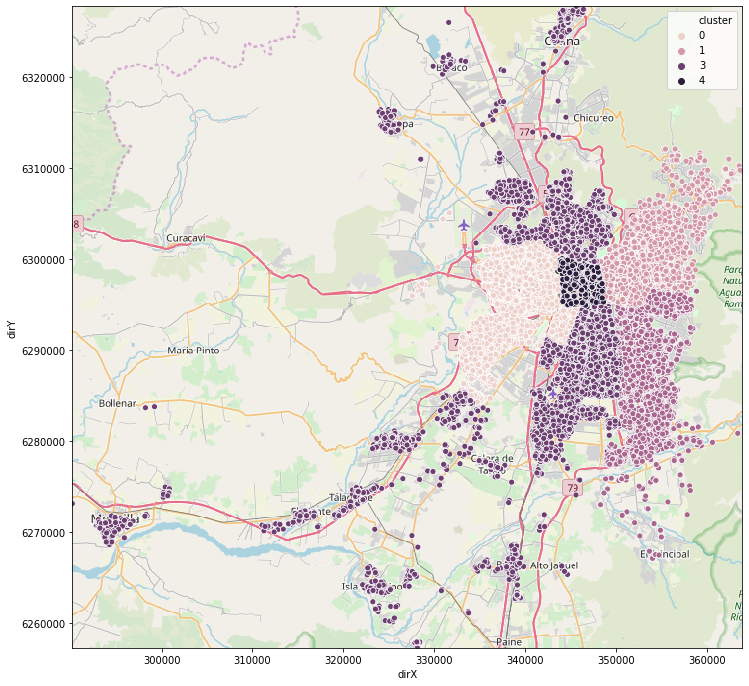

In [191]:
fig, ax = plt.subplots(figsize = (12,15))
ax.scatter(f5_clusters.dirX, f5_clusters.dirY, zorder=1, alpha= 1, s=1)
ax.set_xlim(Bound_Box[0],Bound_Box[1])
ax.set_ylim(Bound_Box[2],Bound_Box[3])
ax.imshow(Map_San, zorder=0, extent = Bound_Box, aspect= 'equal')
sns.scatterplot(x="dirX", y="dirY",
              hue="cluster",
              data=f5_clusters);

Alright, the divisions are very clear and follow a geographical pattern around the area. Let's now try to figure out which one corresponds to each level of acquisition power (rationally, the better the quality of the construction, the more expensive it is, the more money people will have).

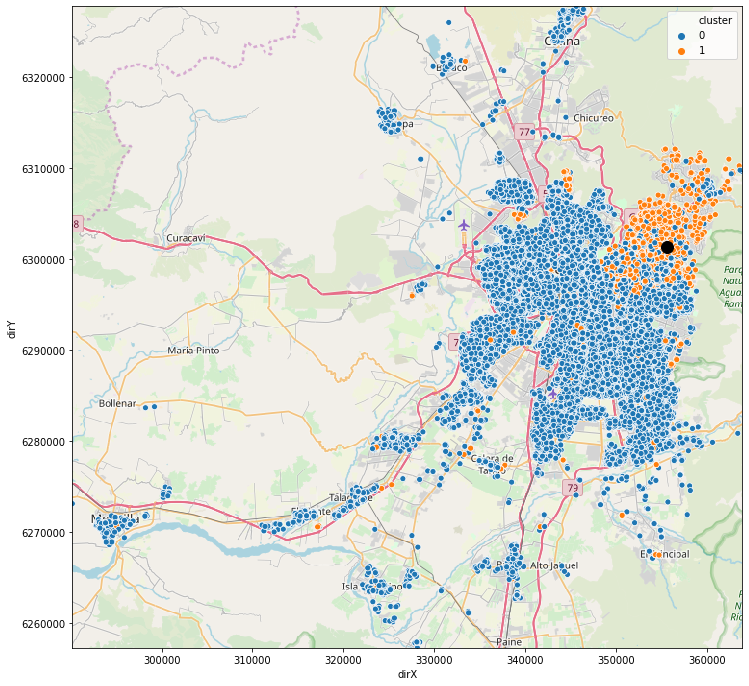

In [192]:
K = 2
k = KMeans(K)

f6 = f4[['MontoArr']]

k.fit(f6,f6.index);
f6_clusters = f6.copy()
f6_clusters['cluster'] = k.fit_predict(f6)
f6_clusters['dirX'] = f4[['DirCoordX']]
f6_clusters['dirY'] = f4[['DirCoordY']]

fig, ax = plt.subplots(figsize = (12,15))
ax.scatter(f6_clusters.dirX, f6_clusters.dirY, zorder=1, alpha= 1, s=1)
ax.plot(nhood[0],nhood[1],'ko', markersize=12)
ax.set_xlim(Bound_Box[0],Bound_Box[1])
ax.set_ylim(Bound_Box[2],Bound_Box[3])
ax.imshow(Map_San, zorder=0, extent = Bound_Box, aspect= 'equal')
sns.scatterplot(x="dirX", y="dirY",
              hue="cluster",
              data=f6_clusters)

In the image above we can clearly see that, not only people tend to pay more in the blue cluster, but that this also concides with the interest point that we added initially to our studies, which is one of the most upscale neighborhoods in Santiago. Next, let's hopefully see that indeed, the people that earn more money also live in that same area:

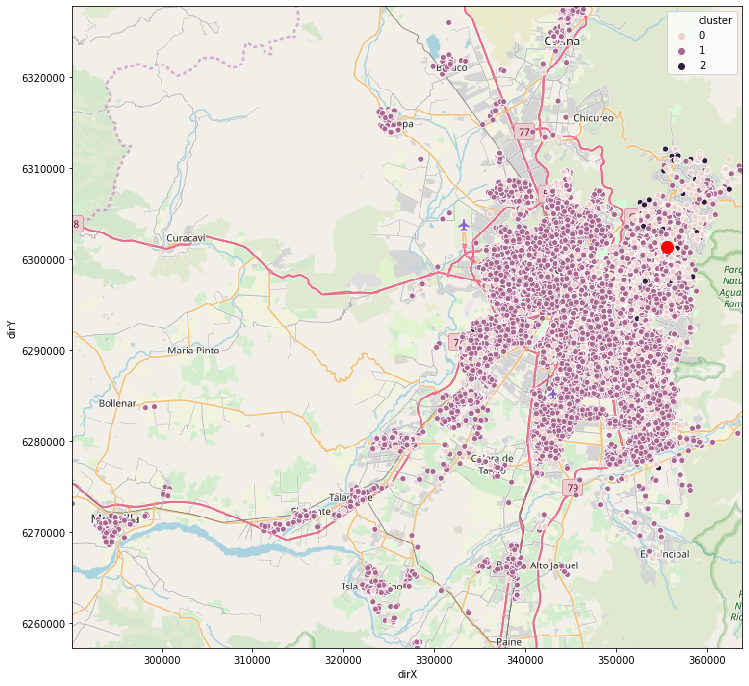

In [202]:
K = 3
k = KMeans(K)

f7 = f4[['IngresoHogar']]

k.fit(f7,f7.index);
f7_clusters = f7.copy()
f7_clusters['cluster'] = k.fit_predict(f7)
f7_clusters['dirX'] = f4[['DirCoordX']]
f7_clusters['dirY'] = f4[['DirCoordY']]

fig, ax = plt.subplots(figsize = (12,15))
ax.scatter(f7_clusters.dirX, f7_clusters.dirY, zorder=1, alpha= 1, s=1)
ax.plot(nhood[0],nhood[1],'ro', markersize=12)
ax.set_xlim(Bound_Box[0],Bound_Box[1])
ax.set_ylim(Bound_Box[2],Bound_Box[3])
ax.imshow(Map_San, zorder=0, extent = Bound_Box, aspect= 'equal')
sns.scatterplot(x="dirX", y="dirY",
              hue="cluster",
              data=f7_clusters)

The division is not as clear as before, but we can still see a concentration of higher income in that area, plus the presence of the people with the highest income in town (cluster 2).

Last but not least, just for fun and to see if years of education actually translate to higher income, let's plot that attribute cluster on the map:

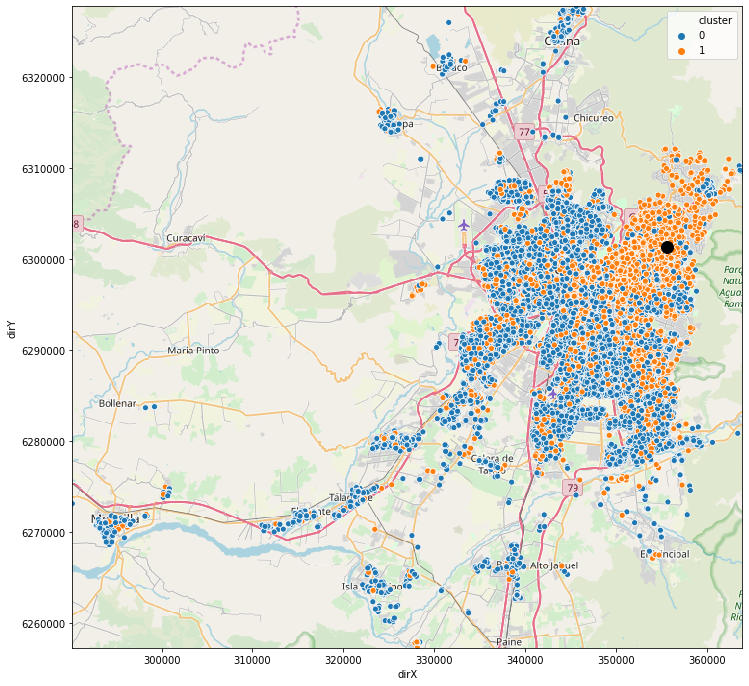

In [203]:
K = 2
k = KMeans(K)

f8 = f4[['AnosEstudio']]

k.fit(f8,f8.index);
f8_clusters = f8.copy()
f8_clusters['cluster'] = k.fit_predict(f8)
f8_clusters['dirX'] = f4[['DirCoordX']]
f8_clusters['dirY'] = f4[['DirCoordY']]

fig, ax = plt.subplots(figsize = (12,15))
ax.scatter(f8_clusters.dirX, f8_clusters.dirY, zorder=1, alpha= 1, s=1)
ax.plot(nhood[0],nhood[1],'ko', markersize=12)
ax.set_xlim(Bound_Box[0],Bound_Box[1])
ax.set_ylim(Bound_Box[2],Bound_Box[3])
ax.imshow(Map_San, zorder=0, extent = Bound_Box, aspect= 'equal')
sns.scatterplot(x="dirX", y="dirY",
              hue="cluster",
              data=f8_clusters)

So there will have it, good thing we are studying = )

--------------------

That wraps up our study for now, since we can safely recommend at least 2 different types of advertisement campaigns for any given local commerce based on location and purchasing power of their potential customers.

# Section 3 - Individual Contributions

Part 1 (data prep): Sushanth 40% / Pedro 60%

Part 2 - Section 1: Sushanth 40% / Pedro 60%

Part 2 - Section 2: Sushanth 35% / Pedro 65%